In [11]:
from dask.distributed import Client

client = await Client(processess=False, asynchronous=True)

In [12]:
import xarray as xr
import fsspec

# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem("reference", fo=f'./gefs_wave/gefswave_kerchunk.json', remote_protocol='s3', remote_options={'anon':True, 'use_ssl': False})
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), chunks={})
ds

<xarray.Dataset>
Dimensions:    (ens: 2, time: 105, latitude: 721, longitude: 1440)
Coordinates:
  * ens        (ens) int32 1 2
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[s] 2023-07-06T12:00:00 ... 2023-07-22T12:00:00
Data variables:
    htsgw      (ens, time, latitude, longitude) float64 dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
Attributes:
    meta:     Generated with gribberishpy

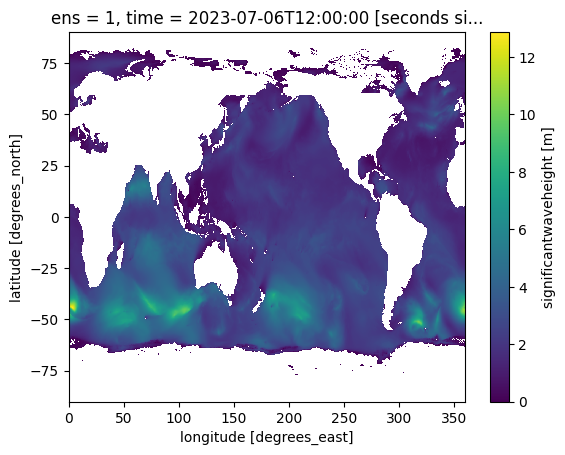

In [7]:
chunk = ds.htsgw.isel(ens=0, time=0)
vals = await client.compute(chunk)
vals.plot()

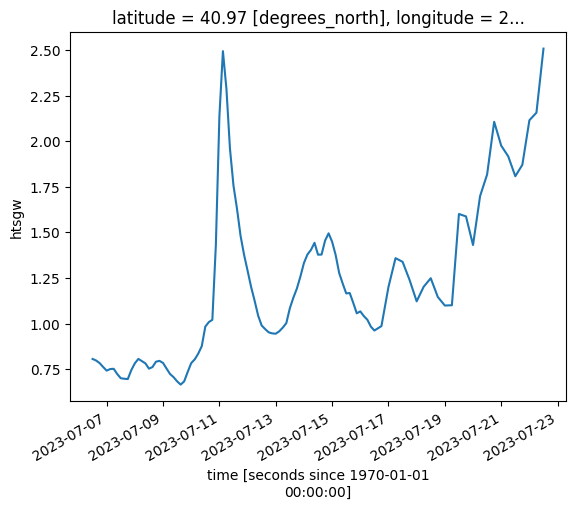

In [13]:
ndbc_44097_latitude = 40.967
ndbc_44097_longitude = 360 - 70.167

ndbc_htsgw = ds.htsgw.interp(latitude=ndbc_44097_latitude, longitude=ndbc_44097_longitude, method='linear')
ndbc_htsgw_max = ndbc_htsgw.max('ens', skipna=True)
sel = await client.compute(ndbc_htsgw_max)
sel.plot()

In [14]:
await client.shutdown()